In [1]:
# --- INSTALLING LIBRARIES ---
!pip install --upgrade transformers accelerate datasets scikit-learn safetensors -q

# --- CORE IMPORTS ---
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
# Import DebertaV2Model for the core model architecture
from transformers import AutoTokenizer, DebertaV2Model, Trainer, TrainingArguments
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer, OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil
import sklearn
from packaging import version
import safetensors.torch # For loading the model weights

RNG = 42
N_CLASSES = 3
class_names = ['Negative', 'Neutral', 'Positive']
MODEL_CHECKPOINT = "microsoft/deberta-v3-base"
NUMERIC_COLS = ['tomatoMeter', 'audienceScore', 'runtimeMinutes']
NUM_NUMERICAL_FEATURES = 3 # Defined in your Part 3

# --- 1. GOOGLE DRIVE MOUNT AND PATHS ---
from google.colab import drive

# 1. Mount Google Drive
print("Mounting Google Drive...")
drive.mount('/content/drive')

# 2. Define Paths based on user input
BASE_DRIVE_PATH = '/content/drive/MyDrive'
# Base folder where the model checkpoints are stored
CHECKPOINT_BASE_FOLDER = 'THESIS 47/Saved Datasets/DeBertaB C2 194k'
# The specific checkpoint with the best F1 score
CHECKPOINT_SUBFOLDER = 'checkpoint-9740'
# The full path to load the best model weights
FINAL_MODEL_LOAD_PATH = os.path.join(BASE_DRIVE_PATH, CHECKPOINT_BASE_FOLDER, CHECKPOINT_SUBFOLDER)
# The path to the dataset file
FILE_PATH = os.path.join(BASE_DRIVE_PATH, 'THESIS 47/Saved Datasets/Composite2_194k data.csv')
# The final directory to save the fully evaluated model
FINAL_MODEL_SAVE_PATH = os.path.join(BASE_DRIVE_PATH, CHECKPOINT_BASE_FOLDER, 'final model debertaB c2 194k')

print(f"\nLoading checkpoint from: {FINAL_MODEL_LOAD_PATH}")
print(f"Loading dataset from: {FILE_PATH}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.9/380.9 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 54.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 17.4 MB/s eta 0:00:00
Mounting Google Drive...
Mounted at /content/drive

Loading checkpoint from: /content/drive/MyDrive/THESIS 47/Saved Datasets/DeBertaB C2 194k/checkpoint-9740
Loading dataset from: /content/drive/MyDrive/THESIS 47/Saved Datasets/Composite2_194k data.csv


In [3]:
# --- 2. MODEL ARCHITECTURE (CRITICAL REDEFINITION) ---
class MultimodalClassifier(nn.Module):
    """
    Multimodal Classifier structure identical to the one used during training (DeBERTa V2-Base).
    """
    def __init__(self, num_labels, num_numerical, num_categorical):
        super().__init__()
        # Initialize DebertaV2Model
        self.deberta = DebertaV2Model.from_pretrained(MODEL_CHECKPOINT)
        self.dropout = nn.Dropout(0.2)
        roberta_hidden_size = self.deberta.config.hidden_size
        self.classifier = nn.Linear(
            roberta_hidden_size + num_numerical + num_categorical,
            num_labels
        )
        self.num_labels = num_labels

    def forward(self, input_ids, attention_mask, numerical_features, categorical_features, labels=None):
        # Call the deberta model
        deberta_output = self.deberta(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = self.dropout(deberta_output.last_hidden_state[:, 0])

        combined = torch.cat([pooled_output, numerical_features, categorical_features], dim=1)
        logits = self.classifier(combined)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        return (loss, logits) if loss is not None else (None, logits)


# --- 3. DATA COLLATOR (CRITICAL REDEFINITION) ---
class MultimodalDataCollator:
    """
    Data Collator to correctly batch all multimodal inputs.
    """
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer
    def __call__(self, features):
        batch = self.tokenizer.pad(
            [{"input_ids": f["input_ids"], "attention_mask": f["attention_mask"]} for f in features],
            return_tensors="pt"
        )
        batch['labels'] = torch.tensor([f['label'] for f in features], dtype=torch.long)
        batch['numerical_features'] = torch.stack([f['numerical_features'] for f in features])
        batch['categorical_features'] = torch.stack([f['categorical_features'] for f in features])
        return batch

# --- DUMMY TRAINER CLASS (Needed for Trainer initialization, loss computation not used) ---
class WeightedTrainer(Trainer):
    # This class is kept for compatibility, even though we are not training (only evaluating)
    # The actual weighted loss logic is bypassed since we only call .predict()
    pass

In [4]:
# --- 4. DATA LOADING AND PREPROCESSING ---
def get_processed_test_data():
    """
    Loads data, splits, and re-fits/applies feature transformers to get the test set.
    """
    print("--- Data Loading and Splitting (Replicating Part 1 & 2) ---")

    try:
        df = pd.read_csv(FILE_PATH)
    except FileNotFoundError:
        raise FileNotFoundError(f"Dataset not found at: {FILE_PATH}. Please check the path in Part 0.")

    df = df.dropna(subset=['reviewText', 'target_label']).copy()
    df['label'] = df['target_label'].astype(int)
    df['title'] = df['title'].fillna("")
    df['genre'] = df['genre'].fillna("Unknown")
    df['combined_text'] = df['title'] + " [SEP] " + df['reviewText']

    # Stratified Split (MUST be identical to training split, RNG=42)
    train_idx, test_idx = train_test_split(
        df.index, test_size=0.2, random_state=RNG, stratify=df['label']
    )
    train_df = df.loc[train_idx].reset_index(drop=True)
    test_df = df.loc[test_idx].reset_index(drop=True)
    y_train = train_df['label'].values.astype(int)

    # --- FEATURE ENGINEERING (Fit on Train) ---
    print("--- Re-fitting Feature Transformers on Training Data ---")

    # 1. Numeric (Scaler)
    train_numeric = train_df[NUMERIC_COLS].copy()
    train_medians = train_numeric.median(numeric_only=True)
    train_numeric = train_numeric.fillna(train_medians)
    scaler = StandardScaler()
    scaler.fit(train_numeric.values) # Fit on training set

    # 2. Categorical: Genre (MultiLabelBinarizer)
    train_genre_list = train_df['genre'].fillna("Unknown").str.split(', ')
    mlb = MultiLabelBinarizer()
    mlb.fit(train_genre_list) # Fit on training set

    # 3. Categorical: Language (OneHotEncoder)
    train_lang = train_df['language_encoded'].astype('Int64').astype(str).fillna('unknown')

    # Handle sklearn version differences
    if version.parse(sklearn.__version__) >= version.parse("1.2"):
        ohe_lang = OneHotEncoder(handle_unknown='ignore', sparse_output=False, dtype=np.float32)
    else:
        ohe_lang = OneHotEncoder(handle_unknown='ignore', sparse=False, dtype=np.float32)

    ohe_lang.fit(train_lang.to_frame()) # Fit on training set

    # 4. Categorical: Director (Target Encoding - Function must be re-defined)
    def director_features_multiclass(train_s, y, test_s, n_splits=5):
        s_train = train_s.fillna("Unknown").astype(str)
        s_test = test_s.fillna("Unknown").astype(str)

        # Frequency (on train)
        freq = s_train.value_counts()
        te_freq = np.log1p(s_test.map(freq).fillna(0).values)[:, None].astype(np.float32)

        # Test set mapping (using full train means)
        n_classes = len(np.unique(y))
        y_ohe = OneHotEncoder(categories=[range(n_classes)], sparse_output=False, dtype=np.float32).fit_transform(y.reshape(-1, 1))
        global_mean = y_ohe.mean(axis=0)

        full_means = pd.DataFrame(y_ohe, index=s_train.index).groupby(s_train).mean()
        test_df_map = s_test.to_frame(name='did')
        merged_test = test_df_map.merge(full_means, left_on='did', right_index=True, how='left')
        te_te = merged_test.drop('did', axis=1).values
        mask_test = np.isnan(te_te.sum(axis=1))
        te_te[mask_test] = global_mean

        # Return test features (frequency and target encoding)
        return np.concatenate([te_freq, te_te], axis=1).astype(np.float32)

    # Apply Director Encoding to test set
    test_dir_block = director_features_multiclass(
        train_df['director_encoded'].astype(str), y_train,
        test_df['director_encoded'].astype(str)
    )

    # --- Feature Building for Test Set ---
    def build_test_features(split_df, dir_block, scaler_obj, mlb_obj, ohe_lang_obj, medians):
        out = {}
        out['combined_text'] = split_df['combined_text'].tolist()
        out['label'] = split_df['label'].astype(int).tolist()

        # Numeric (Apply trained scaler and medians)
        numeric = split_df[NUMERIC_COLS].copy().fillna(medians)
        out['numerical_features'] = scaler_obj.transform(numeric.values).astype(np.float32)

        # Genre (Apply trained mlb)
        genre_list = split_df['genre'].fillna("Unknown").str.split(', ')

        # Concatenate all categorical features
        out['categorical_features'] = np.concatenate([
            mlb_obj.transform(genre_list),
            ohe_lang_obj.transform(split_df['language_encoded'].astype('Int64').astype(str).fillna('unknown').to_frame()),
            dir_block
        ], axis=1).astype(np.float32)

        return out

    print("Building test features dictionary...")
    test_feats = build_test_features(test_df, test_dir_block, scaler, mlb, ohe_lang, train_medians)

    # Calculate categorical feature dimension (needed for model init)
    num_categorical_features = test_feats['categorical_features'].shape[1]
    print(f"Feature Dims: Numeric={NUM_NUMERICAL_FEATURES}, Categorical={num_categorical_features}")

    # HF Dataset
    raw_datasets = DatasetDict({
        'test': Dataset.from_dict(test_feats),
    })

    # Return train_medians, scaler, mlb, ohe_lang for potential later use (e.g., inference)
    return raw_datasets, num_categorical_features, train_medians, scaler, mlb, ohe_lang

# 5. EXECUTE DATA PREPARATION
raw_datasets, NUM_CATEGORICAL_FEATURES, train_medians, scaler, mlb, ohe_lang = get_processed_test_data()

--- Data Loading and Splitting (Replicating Part 1 & 2) ---
--- Re-fitting Feature Transformers on Training Data ---
Building test features dictionary...


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['variety'] will be ignored
  warnings.warn(


Feature Dims: Numeric=3, Categorical=49


In [5]:
# 6. TOKENIZATION (Must match training's tokenizer)
print(f"\nDownloading Tokenizer ({MODEL_CHECKPOINT})...")
# Load tokenizer from the saved model checkpoint folder!
tokenizer = AutoTokenizer.from_pretrained(FINAL_MODEL_LOAD_PATH)

def tokenize_fn(examples):
    # max_length=256 must match training
    return tokenizer(examples["combined_text"], padding="max_length", truncation=True, max_length=256)

print("Tokenizing test dataset...")
tokenized_datasets = raw_datasets.map(tokenize_fn, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["combined_text"])
tokenized_datasets.set_format("torch")
test_dataset = tokenized_datasets["test"]

print("--- Data Ready for Evaluation ---")

# --- 7. LOAD THE TRAINED MODEL (FIXED FOR SAFETENSORS) ---
print("\nLoading trained model and custom weights...")
try:
    # 1. Initialize the custom model structure
    model = MultimodalClassifier(N_CLASSES, NUM_NUMERICAL_FEATURES, NUM_CATEGORICAL_FEATURES)

    # 2. Load weights from 'model.safetensors' in the checkpoint folder
    WEIGHTS_FILE = "model.safetensors"
    model_weights = safetensors.torch.load_file(os.path.join(FINAL_MODEL_LOAD_PATH, WEIGHTS_FILE))

    # 3. Load weights into the model
    model.load_state_dict(model_weights)

    # 4. Move to GPU/CPU and set to evaluation mode
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

except Exception as e:
    print(f"\n❌ CRITICAL ERROR: Could not load the model from {FINAL_MODEL_LOAD_PATH}")
    print(f"Please confirm that '{WEIGHTS_FILE}' exists in that folder.")
    print(f"Error details: {e}")
    raise

print("✅ Model loaded successfully from checkpoint-9740.")


Tokenizing test dataset...


Map:   0%|          | 0/38957 [00:00<?, ? examples/s]

--- Data Ready for Evaluation ---

Loading trained model and custom weights...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

✅ Model loaded successfully from checkpoint-9740.


In [6]:
# --- 8. DEFINE METRICS FUNCTION ---
def compute_metrics(pred):
    labels = pred.label_ids

    if isinstance(pred.predictions, tuple):
        predictions = pred.predictions[0]
    else:
        predictions = pred.predictions

    preds = predictions.argmax(-1)

    prec, rec, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted', zero_division=0)
    acc = accuracy_score(labels, preds)

    return {'accuracy': acc, 'f1_weighted': f1, 'precision': prec, 'recall': rec}

# --- 9. SETUP DUMMY TRAINER FOR PREDICTION ---
training_args = TrainingArguments(
    output_dir="/tmp/dummy_trainer",
    per_device_eval_batch_size=16,
    report_to="none",
)

# Trainer initialization
eval_trainer = WeightedTrainer(
    model=model,
    args=training_args,
    data_collator=MultimodalDataCollator(tokenizer),
    compute_metrics=compute_metrics,
)

# --- 10. EVALUATION ---
print("\n--- Starting Final Evaluation on Test Set ---")
try:
    # Run prediction to get the logits
    preds_output = eval_trainer.predict(test_dataset)
    metrics = preds_output.metrics
    print(f"✅ Evaluation Metrics: {metrics}")

    # Process predictions
    if isinstance(preds_output.predictions, tuple):
        logits = preds_output.predictions[0]
    else:
        logits = preds_output.predictions

    pred_labels = np.argmax(logits, axis=-1)
    true_labels = np.array(test_dataset["label"])

    # Store results for the next plotting cell
    global global_true_labels, global_pred_labels, global_class_names, global_eval_trainer
    global_true_labels = true_labels
    global_pred_labels = pred_labels
    global_class_names = class_names
    global_eval_trainer = eval_trainer


except Exception as e:
    print(f"\n❌ A runtime error occurred during prediction: {e}")
    raise

You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



--- Starting Final Evaluation on Test Set ---


✅ Evaluation Metrics: {'test_loss': 0.6262656450271606, 'test_model_preparation_time': 0.0252, 'test_accuracy': 0.7194342480170445, 'test_f1_weighted': 0.7148353409711359, 'test_precision': 0.7129359476889798, 'test_recall': 0.7194342480170445, 'test_runtime': 711.9505, 'test_samples_per_second': 54.719, 'test_steps_per_second': 3.42}



--- Generating Final Reports and Plots ---

--- Classification Report (Test Set) ---
              precision    recall  f1-score   support

    Negative     0.7107    0.7173    0.7140     11006
     Neutral     0.6210    0.5511    0.5840     13216
    Positive     0.7970    0.8720    0.8328     14735

    accuracy                         0.7194     38957
   macro avg     0.7096    0.7135    0.7103     38957
weighted avg     0.7129    0.7194    0.7148     38957


--- Generating Confusion Matrix Plots ---


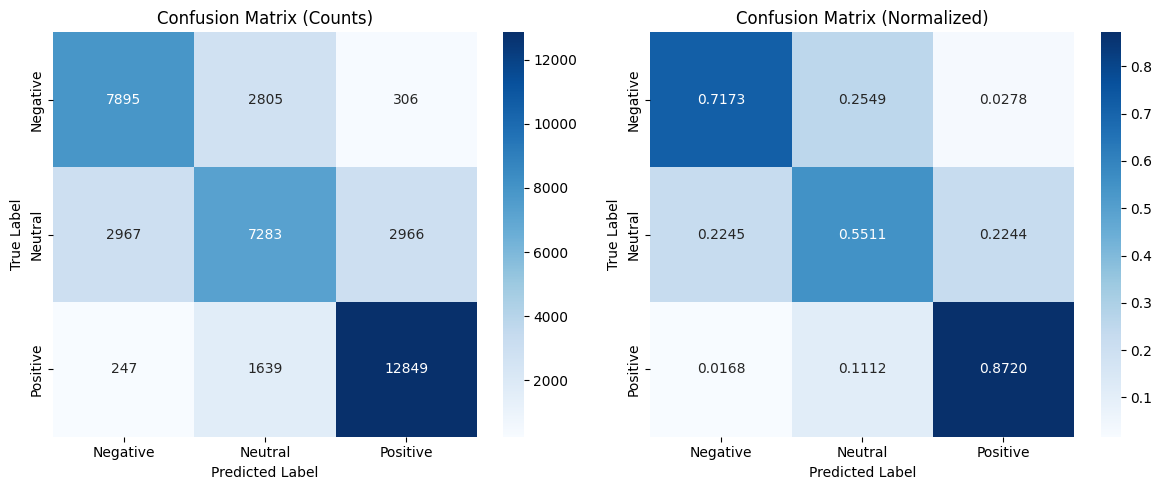


--- Generating Per-Class Metric Bar Chart ---


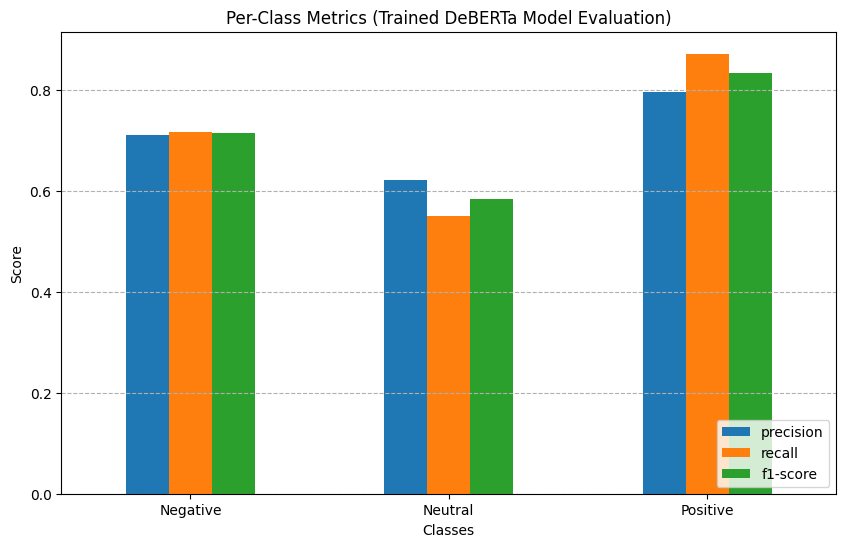


💾 Saving final model to Google Drive at: /content/drive/MyDrive/THESIS 47/Saved Datasets/DeBertaB C2 194k/final model debertaB c2 194k...
✅ DONE! The final model has been saved to: /content/drive/MyDrive/THESIS 47/Saved Datasets/DeBertaB C2 194k/final model debertaB c2 194k


In [7]:
# --- EVALUATE • REPORT • PLOTS • SAVE ---

# Safety check for variables passed from the previous cell
if 'global_true_labels' not in globals():
    raise ValueError("Evaluation data is missing. Please run Part 4 first.")

true_labels = global_true_labels
pred_labels = global_pred_labels
class_names = global_class_names
trainer = global_eval_trainer

print("\n--- Generating Final Reports and Plots ---")

# 1. CLASSIFICATION REPORT
print("\n--- Classification Report (Test Set) ---")
report_dict = classification_report(true_labels, pred_labels, target_names=class_names, output_dict=True, digits=4)
print(classification_report(true_labels, pred_labels, target_names=class_names, digits=4))

# 2. CONFUSION MATRIX
print("\n--- Generating Confusion Matrix Plots ---")
cm = confusion_matrix(true_labels, pred_labels)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(12, 5))

# Counts (Integers)
plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Counts)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Normalized (Floats with 4 decimals)
plt.subplot(1, 2, 2)
sns.heatmap(cm_norm, annot=True, fmt='.4f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Normalized)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.tight_layout()
plt.show()

# 3. PER-CLASS BAR CHART
print("\n--- Generating Per-Class Metric Bar Chart ---")
report_df = pd.DataFrame(report_dict).transpose()
report_df_classes = report_df.loc[[cn for cn in class_names if cn in report_df.index]]
ax = report_df_classes[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(10, 6))
plt.title('Per-Class Metrics (Trained DeBERTa Model Evaluation)')
plt.xlabel('Classes'); plt.ylabel('Score')
plt.xticks(rotation=0); plt.grid(axis='y', linestyle='--'); plt.legend(loc='lower right')
plt.show()


# 4. FINAL SAVING TO GOOGLE DRIVE
print(f"\n💾 Saving final model to Google Drive at: {FINAL_MODEL_SAVE_PATH}...")
# trainer.save_model saves the model weights (model.safetensors) and tokenizer config
trainer.save_model(FINAL_MODEL_SAVE_PATH)

print(f"✅ DONE! The final model has been saved to: {FINAL_MODEL_SAVE_PATH}")